<a href="https://colab.research.google.com/github/Hyenni/kaggle/blob/master/digit_recognizer_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### kaggle competition (digit-recognizer)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from google.colab import files
files.upload()

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [9]:
!kaggle competitions download -c digit-recognizer

 94% 69.0M/73.2M [00:01<00:00, 31.3MB/s]
100% 73.2M/73.2M [00:01<00:00, 44.5MB/s]
 90% 44.0M/48.8M [00:00<00:00, 68.0MB/s]
100% 48.8M/48.8M [00:00<00:00, 123MB/s] 
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 78.4MB/s]


In [10]:
!ls -al

total 125160
drwxr-xr-x 1 root root     4096 Aug 20 07:52 .
drwxr-xr-x 1 root root     4096 Aug 20 07:46 ..
drwxr-xr-x 1 root root     4096 Aug 13 16:04 .config
drwx------ 3 root root     4096 Aug 20 07:48 drive
-rwxrwxrwx 1 root root       62 Aug 20 07:49 kaggle.json
drwxr-xr-x 1 root root     4096 Aug  2 16:06 sample_data
-rw-r--r-- 1 root root   240909 Aug 20 07:52 sample_submission.csv
-rw-r--r-- 1 root root 51118296 Aug 20 07:52 test.csv
-rw-r--r-- 1 root root 76775041 Aug 20 07:52 train.csv


In [0]:
!mkdir input
!cp train.csv input/
!cp test.csv input/
!cp sample_submission.csv input/

In [12]:
!ls -al input/

total 125144
drwxr-xr-x 2 root root     4096 Aug 20 07:53 .
drwxr-xr-x 1 root root     4096 Aug 20 07:53 ..
-rw-r--r-- 1 root root   240909 Aug 20 07:53 sample_submission.csv
-rw-r--r-- 1 root root 51118296 Aug 20 07:53 test.csv
-rw-r--r-- 1 root root 76775041 Aug 20 07:53 train.csv


In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #for plotting
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras.optimizers import RMSprop

Using TensorFlow backend.


### 1. Data Preparation
#### load data 

In [0]:
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

### check data

In [16]:
print(train.shape)
print(test.shape)
train.head()

(42000, 785)
(28000, 784)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Counter({1: 4684, 7: 4401, 3: 4351, 9: 4188, 2: 4177, 6: 4137, 0: 4132, 4: 4072, 8: 4063, 5: 3795})


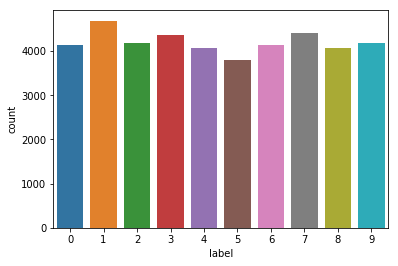

In [18]:
print(Counter(train['label']))
sns.countplot(train['label'])

### transform data

In [0]:
x_train = (train.iloc[:,1:].values).astype('float32')
y_train = train.iloc[:,0].values.astype('int32')

x_test = test.values.astype('float32')

In [20]:
print(train.iloc[:,1:].values)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [21]:
print(train.iloc[:,0].values)

[1 0 1 ... 7 6 9]


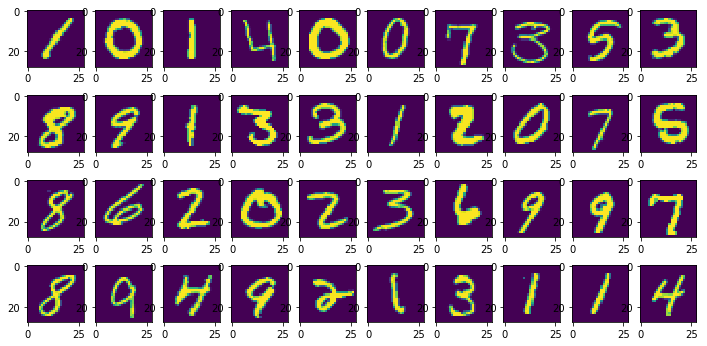

In [22]:
%matplotlib inline
plt.figure(figsize=(12,6))
x, y = 10, 4
for i in range(40):
    plt.subplot(y, x, i+1)
    plt.imshow(x_train[i].reshape((28,28)), interpolation='nearest')
plt.show()

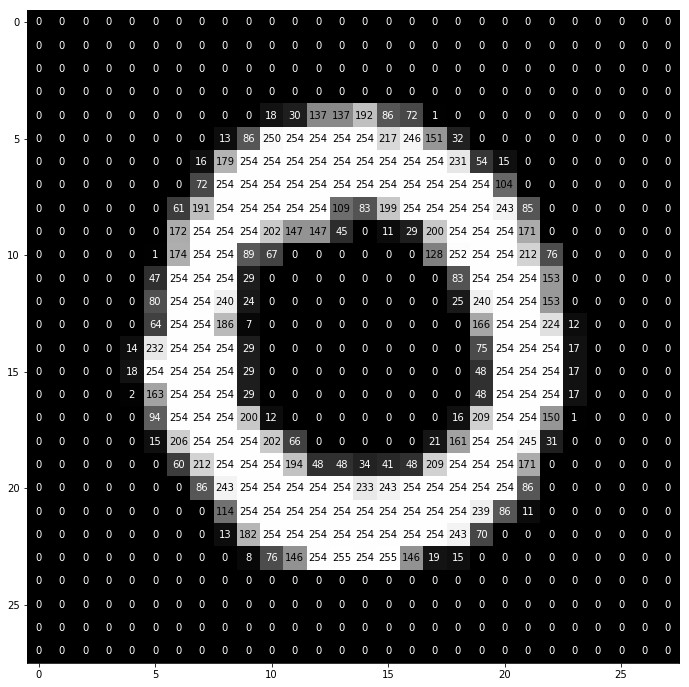

In [23]:
def visualize_input(img, ax):
    ax.imshow(img, cmap='gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y],2)), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')

x_train=(train.iloc[:,1:].values).astype('int32')
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
visualize_input(x_train[1].reshape(28,28), ax)
x_train=(train.iloc[:,1:].values).astype('float32')

### normaliztion

In [24]:
x_train = x_train/255.0
x_test = x_test/255.0
y_train

array([1, 0, 1, ..., 7, 6, 9], dtype=int32)

In [0]:
print(x_train[0])

In [26]:
print('x_train shape:', x_train.shape)

x_train shape: (42000, 784)


### reshape

In [0]:
# X_train = x_train.reshape(x_train.shape[0],28,28,1)
X_train = x_train.reshape(-1, 28, 28, 1) 
X_test = x_test.reshape(-1, 28, 28, 1)

In [28]:
print(x_train.shape[0])

42000


In [29]:
print(X_train.shape)

(42000, 28, 28, 1)


In [30]:
print(X_train[0][5])

[[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.7490196 ]
 [0.98039216]
 [0.99215686]
 [0.3647059 ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]


### label encoding

In [0]:
num_classes = 10

y_train = keras.utils.to_categorical(y_train, num_classes)

X_train, X_val, Y_train, Y_val= train_test_split(
    X_train, y_train, test_size = 0.1, random_state = 2)

In [32]:
print(y_train)

[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [0]:
batch_size = 128
epochs = 10
input_shape = (28, 28, 1)

model = Sequential()

model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', 
                kernel_initializer = 'he_normal', input_shape = input_shape))
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', 
                kernel_initializer = 'he_normal'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.20))
model.add(Conv2D(64, (3, 3), activation='relu',
                 padding='same', kernel_initializer='he_normal'))
model.add(Conv2D(64, (3, 3), activation='relu',
                 padding='same',kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu',
                 padding='same',kernel_initializer='he_normal'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation = 'softmax'))
          
model.compile(loss=keras.losses.categorical_crossentropy,
                       optimizer = keras.optimizers.Adam(),
                         metrics = ['accuracy'])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                           patience = 3,
                                           verbose = 1,
                                           factor = 0.5,
                                           min_lr = 0.0001)

In [0]:
datagen = ImageDataGenerator(featurewise_center=False, # set input mean to 0 over the dataset
                            samplewise_center = False, # set each sample mean to 0
                            featurewise_std_normalization = False, # divide inputs by std of the dataset
                            samplewise_std_normalization = False, # divide each input by its std
                            zca_whitening = False, # apply ZCA whitening
                            rotation_range = 10, # randomly rotate images in the range (degrees, 0 to 180)
                            zoom_range = 0.1, # Randomly zoom image 
                            width_shift_range = 0.1, # randomly shift images horizontally (fraction of total width)
                            height_shift_range = 0.1, # randomly shift images vertically (fraction of total height)
                            horizontal_flip = False, # randomly flip images
                            vertical_flip = False) # randomly flip images - we do not want this as it e.g. messes up the digits 6 and 9

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
__________

In [38]:
datagen.fit(X_train)
h = model.fit_generator(datagen.flow(X_train, Y_train, batch_size = batch_size),
                       epochs = epochs,
                       validation_data = (X_val, Y_val),
                       verbose = 1,
                       steps_per_epoch = X_train.shape[0] // batch_size,
                       callbacks = [learning_rate_reduction],)

Epoch 1/10
295/295 [==============================] - 135s 458ms/step - loss: 0.4640 - acc: 0.8530 - val_loss: 0.0620 - val_acc: 0.9810
Epoch 2/10
295/295 [==============================] - 133s 450ms/step - loss: 0.1159 - acc: 0.9645 - val_loss: 0.0654 - val_acc: 0.9807
Epoch 3/10
295/295 [==============================] - 133s 451ms/step - loss: 0.0872 - acc: 0.9742 - val_loss: 0.0389 - val_acc: 0.9895
Epoch 4/10
295/295 [==============================] - 134s 453ms/step - loss: 0.0685 - acc: 0.9788 - val_loss: 0.0480 - val_acc: 0.9874
Epoch 5/10
295/295 [==============================] - 133s 451ms/step - loss: 0.0609 - acc: 0.9817 - val_loss: 0.0333 - val_acc: 0.9905
Epoch 6/10
295/295 [==============================] - 133s 452ms/step - loss: 0.0542 - acc: 0.9833 - val_loss: 0.0228 - val_acc: 0.9931
Epoch 7/10
295/295 [==============================] - 133s 451ms/step - loss: 0.0523 - acc: 0.9840 - val_loss: 0.0340 - val_acc: 0.9914
Epoch 8/10
295/295 [============================

In [39]:
final_loss, final_acc = model.evaluate(X_val, Y_val, verbose=0)
print("validation loss: {0:.6f}, validation accuracy: {1:.6f}".format(final_loss, final_acc))

validation loss: 0.016341, validation accuracy: 0.994286


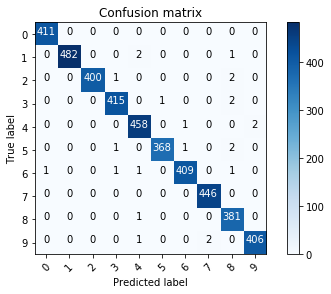

In [40]:
def plot_confusion_matrix(cm, classes,
                         normalize = False,
                         title = 'Confusion matrix',
                         cmap = plt.cm.Blues):
    plt.imshow(cm, interpolation = 'nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(num_classes))

In [41]:
print(h.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


Text(0.5, 1.0, 'training and validation loss')

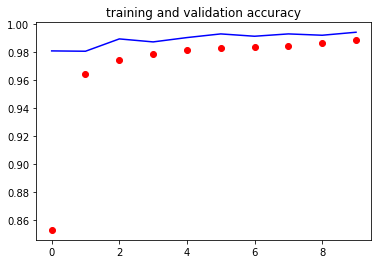

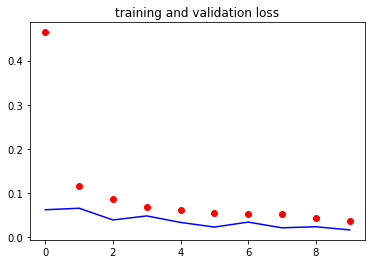

In [47]:
accuracy = h.history['acc']
val_accuracy = h.history['val_acc']
loss = h.history['loss']
val_loss = h.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'ro', label = 'training accuracy')
plt.plot(epochs, val_accuracy, 'b', label = 'validation accuracy')

plt.title('training and validation accuracy')

plt.figure()
plt.plot(epochs, loss, 'ro', label = 'training loss')
plt.plot(epochs, val_loss, 'b', label = 'validation loss')
plt.title('training and validation loss')

In [0]:
predicted_classes = model.predict_classes(X_test)

In [0]:
submissions = pd.DataFrame({"ImageId": list(range(1, len(predicted_classes)+1)),
                           "Label": predicted_classes})
submissions.to_csv("submission.csv", index = False, header = True)

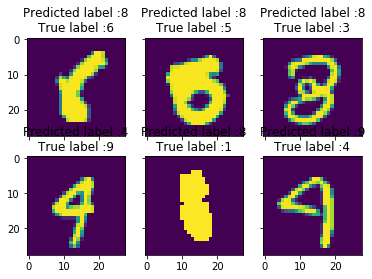

In [45]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)